In [1]:
%%bash
# Install deps from 
# https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md#-linux
apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip

# Boost libraries
apt-get install libboost-all-dev

# Lua binding dependencies
apt-get install liblua5.1-dev

Reading package lists...
Building dependency tree...
Reading state information...
build-essential is already the newest version (12.4ubuntu1).
libjpeg-dev is already the newest version (8c-2ubuntu8).
unzip is already the newest version (6.0-21ubuntu1).
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
git is already the newest version (1:2.17.1-1ubuntu0.7).
tar is already the newest version (1.29b-2ubuntu0.1).
The following additional packages will be installed:
  autoconf automake autopoint bsdmainutils bzip2-doc dbus debhelper
  dh-autoreconf dh-strip-nondeterminism freepats gettext gettext-base
  gir1.2-atk-1.0 gir1.2-freedesktop gir1.2-gdkpixbuf-2.0 gir1.2-gtk-2.0
  gir1.2-ibus-1.0 gir1.2-pango-1.0 groff-base intltool-debian
  libarchive-cpio-perl libarchive-zip-perl libasound2-dev libatk1.0-dev
  libaudio2 libcairo-script-interpreter2 libcairo2-dev libcapnp-0.6.1
  libdbus-1-3 libdbus-1-dev libdrm-dev 

debconf: delaying package configuration, since apt-utils is not installed


In [2]:
!pip install vizdoom

     |████████████████████████████████| 4.9 MB 1.3 MB/s eta 0:00:01
  Created wheel for vizdoom: filename=vizdoom-1.1.7-py3-none-any.whl size=14312177 sha256=aa302449b67f31e3596f0f4b99863e2d3913328c50be4ee71f8575bb977f91ab
  Stored in directory: /root/.cache/pip/wheels/e3/78/dd/a11a3b2e29e59f1756d8d1cf581026ac30fabbb5a037f94a47
Successfully built vizdoom


In [3]:
!git clone https://github.com/simoninithomas/Deep_reinforcement_learning_Course.git

Cloning into 'Deep_reinforcement_learning_Course'...
remote: Enumerating objects: 872, done.
remote: Total 872 (delta 0), reused 0 (delta 0), pack-reused 872
Receiving objects: 100% (872/872), 230.09 MiB | 34.41 MiB/s, done.
Resolving deltas: 100% (385/385), done.
Checking out files: 100% (216/216), done.


In [4]:
from __future__ import division
from __future__ import print_function
import itertools as it
from random import sample, randint, random
from time import time, sleep
import numpy as np
import skimage.color, skimage.transform
import tensorflow as tf
from tqdm import trange
import vizdoom as vzd
from argparse import ArgumentParser

In [5]:
!cat "Deep_reinforcement_learning_Course/Deep Q Learning/Doom/basic.cfg"

# Lines starting with # are treated as comments (or with whitespaces+#).
# It doesn't matter if you use capital letters or not.
# It doesn't matter if you use underscore or camel notation for keys, e.g. episode_timeout is the same as episodeTimeout.

doom_scenario_path = basic.wad
doom_map = map01

# Rewards
living_reward = -1

# Rendering options
screen_resolution = RES_160X120
screen_format = GRAY8
render_hud = True
render_crosshair = false
render_weapon = true
render_decals = true
render_particles = true
window_visible = true

# make episodes start after 20 tics (after unholstering the gun)
episode_start_time = 14

# make episodes finish after 300 actions (tics)
episode_timeout = 300

# Available buttons
available_buttons = 
	{ 
		MOVE_LEFT 
		MOVE_RIGHT 
		ATTACK 
	}

# Game variables that will be in the state
available_game_variables = { AMMO2}

mode = PLAYER
doom_skill = 5


In [6]:
#DEFAULT_MODEL_SAVEFILE = "drive/My Drive/Colab Notebooks/tmp/model"
DEFAULT_CONFIG = "Deep_reinforcement_learning_Course/Deep Q Learning/Doom/basic.cfg"
DEFAULT_SCN = "Deep_reinforcement_learning_Course/Deep Q Learning/Doom/basic.wad"

In [7]:
# Creates and initializes ViZDoom environment.
def initialize_vizdoom(config_file_path , scenario_file_path):
    print("Initializing doom...")
    game = vzd.DoomGame()
    game.load_config(config_file_path)
    game.set_doom_scenario_path(scenario_file_path)
    game.set_window_visible(False)
    game.set_mode(vzd.Mode.PLAYER)
    game.set_screen_format(vzd.ScreenFormat.GRAY8)
    game.set_screen_resolution(vzd.ScreenResolution.RES_640X480)
    game.init()
    print("Doom initialized.")
    return game

In [ ]:
doom=initialize_vizdoom(DEFAULT_CONFIG , DEFAULT_SCN)

In [8]:
import random
import time
import matplotlib.pyplot as plt
def test_environment(game):
    shoot = [0, 0, 1]
    left = [1, 0, 0]
    right = [0, 1, 0]
    actions = [shoot, left, right]

    episodes = 1
    for i in range(episodes):
        game.new_episode()
        while not game.is_episode_finished():
            state = game.get_state()
            img = state.screen_buffer
            misc = state.game_variables
            action = random.choice(actions)
            print(action)
            reward = game.make_action(action)
            print ("\treward:", reward)
            time.sleep(0.02)
        print ("Result:", game.get_total_reward())
        time.sleep(2)
    game.close()

In [9]:
import random                # Handling random number generation
import time                  # Handling time calculation
from skimage import transform# Help us to preprocess the frames

from collections import deque# Ordered collection with ends
from collections import namedtuple
import torch
import torch.optim as optim
import numpy as np
stacked_size = 4

def preprocess(frame):
    """
    screen frames are in grayscale format defalut
    1.normalize the images
    2. apply some transformations
    """
    frame = frame / 255.0
    frame = transform.resize(frame ,[96,96])
    
    return frame
    
    
def stack_frames(stacked_frames , frame , new_episode=False):
    """
    stack multiple frames with each other to idenitify the temporal movemnts of the objects
    1. preprocess the new frame
    """
    processed_frame = preprocess(frame)
    if(new_episode):
        stacked_frames = deque([ np.zeros([96,96] ,dtype=int) for i_dx in range(stacked_size) ] , maxlen=stacked_size)
        #for initial step after new episode add same frame to all the stacked frames
        stacked_frames.append(processed_frame)
        stacked_frames.append(processed_frame)
        stacked_frames.append(processed_frame)
        stacked_frames.append(processed_frame)
        
        stack_states = np.stack(stacked_frames , axis=0)
        
        return stack_states , stacked_frames
    
    else:
        stacked_frames.append(processed_frame)
        
        stack_states = np.stack(stacked_frames , axis=0)
        
        return stack_states , stacked_frames

In [10]:
device='cuda:0' if torch.cuda.is_available() else 'cpu'
class ReplayBuffer :
    def __init__(self , batch_size , buffer_size , seed):
        self.batch_size = batch_size 
        self.buffer_size = buffer_size 
        self.seed = seed
        random.seed(self.seed)
        self.memory = deque(maxlen=self.buffer_size)
        self.experience = namedtuple('Experience' , field_names=['state','action','reward','next_state','done'])
        
    def add(self , state , action , reward , next_state , done):
        experience = self.experience(state , action , reward , next_state , done)
        self.memory.append(experience)
        
    def sample(self):
        
        experinece_batch = random.sample(self.memory , k=self.batch_size)
        
        states = torch.from_numpy( np.stack([ e.state.reshape(4,96,96) for e in experinece_batch if e is not None ],axis=0) ).float().to(device)
        action = torch.from_numpy( np.stack([ (e.action).reshape(1,) for e in experinece_batch if e is not None] , axis=0) ).long().to(device)
        reward = torch.from_numpy( np.stack([ np.array((e.reward)).reshape(1,) for e in experinece_batch if e is not None] , axis=0) ).float().to(device)
        next_state = torch.from_numpy( np.stack([ e.next_state.reshape(4,96,96) for e in experinece_batch if e is not None ] , axis=0) ).float().to(device)
        done = torch.from_numpy( np.stack([ np.array((e.done)).reshape(1,) for e in experinece_batch if e is not None], axis=0).astype(np.uint8) ).float().to(device)
        
        return ( states , action , reward , next_state , done )
    
    def __len__(self):
        return len(self.memory)

In [11]:
BATCH_SIZE = 16
UPDATE_EVERY = 4
SEED= 1244
BUFFER_SIZE=int(1e3)
GAMMA= 0.99
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 

class Agent :
    def __init__(self,state_size , action_size , seed):
        
        self.state_size  = state_size 
        self.action_size = action_size
        self.seed  = random.seed(seed)
        self.train_loss = deque(maxlen=500)
        """
        step --> add the data to experience tuple and if in the update instance train the model
        act --> output the action for states
        learn --> train the model using experince tuple
        soft_update --> update the target network 
        """
        """
        1 --> define local and target  Q networks
        2 --> initialize the optimizer
        3 --> initialize the raply buffer
        
        """
        self.q_local = DeepQNet(self.state_size , self.action_size , seed).to(device)
        self.q_target = DeepQNet(self.state_size , self.action_size , seed).to(device)
        self.optimizer = optim.Adam(self.q_local.parameters() , lr=LR)
        
        self.replay_buffer = ReplayBuffer(BATCH_SIZE , BUFFER_SIZE , SEED)
        self.t_step = 0    # for determine the update instances
        
    def step(self,state , action , reward , next_state , done):
        
        self.replay_buffer.add(state , action , reward , next_state , done)
        self.t_step = (self.t_step + 1)%UPDATE_EVERY
        if(self.t_step == 0):
            if(len(self.replay_buffer) > BATCH_SIZE):
                train_sample = self.replay_buffer.sample()
                self.learn(train_sample , GAMMA)
                
    def learn(self , train_sample , GAMMA) :
        
        state , action , reward , next_state , done = train_sample
        """
        1 --> infernce the local model with state and take the Q values for actions associated
        2 --> indernce the target model and get the maximum Q value
        3 --> obtain the q target with ( reward + GAMMA * max(Q_target_model(next_state))*(1-dones))
        4 --> MSELoss(Q_local , Q_target)
        5 --> optimize the model
        """
        Q_expected = self.q_local(state).gather(1,action)
        Q_target = self.q_target(next_state).detach().max(1)[0].unsqueeze(1)
        Q_target = reward + GAMMA*(Q_target*(1-done))
        
        q_loss = F.mse_loss(Q_expected , Q_target)
        self.train_loss.append(q_loss.to('cpu').detach().item())
        # reset the optimizer
        self.optimizer.zero_grad()
        q_loss.backward()
        self.optimizer.step()
        
        #update the weights of target model weights
        self.soft_update(self.q_target , self.q_local ,TAU)
        
    def act(self , state , eps=0.):
        """
        expand the dim 0 of the state tensor
        base on eps either select max action or a random action
        """
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.q_local.eval()
        with torch.no_grad():
            action_tensor = self.q_local(state_tensor)
        self.q_local.train()
        
        # if the random.random > eps --> select a random action else select greedy action
        if(random.random() > eps ):
            return np.argmax(action_tensor.to('cpu').detach().numpy())
        
        else :
            return random.choice(np.arange(self.action_size))
        
    def soft_update(self , target_model , local_model , tau) :
        
        for target_param , local_param in zip(target_model.parameters() , local_model.parameters()):
            
            target_param.data.copy_(tau*local_param.data + (1.-tau)*target_param.data)
        

In [12]:
import torch.nn as nn
import torch.nn.functional as F

In [13]:
def conv_block(in_channels , out_channles , kernel_size =3 , stride=1 , padding=1 , batch_norm=True , maxpool=False ):
    layers =[]
    conv_layer = nn.Conv2d(in_channels=in_channels , out_channels=out_channles , kernel_size=kernel_size ,
                          stride=stride , padding=padding , padding_mode='reflect', bias=False)
    layers.append(conv_layer)
    
    if(batch_norm):
        bn = nn.BatchNorm2d(out_channles)
        layers.append(bn)
    layers.append(nn.ReLU())
    
    if(maxpool):
        max_layer = nn.MaxPool2d(kernel_size=4, stride=2 , padding=1)
        layers.append(max_layer)
        
    return nn.Sequential(*layers)

In [14]:
class DeepQNet(nn.Module):
    def __init__(self,stack_size , action_size , seed):
        super(DeepQNet , self).__init__()
        """
        define a simple model with some conv layers and later with fully connected layers
        """
        self.in_size = stack_size
        self.out_size = action_size
        self.seed = torch.manual_seed(seed)
        # 224 * 224 * 4 --> 224 * 224 * 32
        self.conv_block1 = conv_block(self.in_size , 32 )
        # 224 * 224 * 32 --> 112 * 112 * 64
        self.conv_block2 = conv_block(32 , 64 , maxpool=True)
        #112 * 112 * 64 --> 112 * 112 * 128
        self.conv_block3 = conv_block(64 , 128 )
        # 112 * 112 * 128 --> 56 * 56 * 256
        self.conv_block4 = conv_block(128,256,maxpool=True)
        # 56 * 56 * 256 --> 56 * 56 * 512
        self.conv_block5 = conv_block(256 , 512)
        # 56 * 56 * 512 --> 28 * 28 * 1024 
        self.conv_block6 = conv_block(512 , 1024 , maxpool=True)
        self.flatten_size = 12*12*1024
        self.fc1 = nn.Linear(self.flatten_size , 512)
        self.fc_bn = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512 , self.out_size)
        
    def forward(self, x):

        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = self.conv_block6(x)
        x = x.view(-1,self.flatten_size)
        x = F.dropout(F.relu(self.fc_bn(self.fc1(x))) ,p=0.4 )
        x = self.fc2(x) 
        
        return x

In [15]:
agent = Agent(state_size=4, action_size=3, seed=1243)

In [16]:
agent.q_local.load_state_dict(torch.load('../input/doom-rl/local_model.pth'))
agent.q_target.load_state_dict(torch.load('../input/doom-rl/target_model.pth'))

<All keys matched successfully>

In [18]:
# Init the game
shoot = [0, 0, 1]
left = [1, 0, 0]
right = [0, 1, 0]
actions = [shoot, left, right]
total_episodes=2500
game = initialize_vizdoom(DEFAULT_CONFIG , DEFAULT_SCN)
explore_probability = 0.4746
explore_probability_end=0.01
eps_decay = 0.9995
max_steps = 500
for episode in range(total_episodes):
    # Set step to 0
    step = 0
            
    # Initialize the rewards of the episode
    episode_rewards = []
            
    # Make a new episode and observe the first state
    game.new_episode()
    state = game.get_state().screen_buffer
            
    # Remember that stack frame function also call our preprocess function.
    state, stacked_frames = stack_frames(None, state, True)

    while step < max_steps:
        step += 1 
        # Predict the action to take and take it
        action  = agent.act(state , eps=explore_probability)

        # Do the action
        reward = game.make_action(actions[action])

        # Look if the episode is finished
        done = game.is_episode_finished()
                
        # Add the reward to total reward
        episode_rewards.append(reward)

        # If the game is finished
        if done:
            # the episode ends so no next state
            next_state = np.zeros((96,96), dtype=np.int)
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)

            # Set step = max_steps to end the episode
            step = max_steps

            # Get the total reward of the episode
            total_reward = np.sum(episode_rewards)
            if(episode%10==0):
                print('Episode: {}'.format(episode),
                        'Total reward: {}'.format(total_reward),
                        'Training loss: {:.4f}'.format(np.mean(agent.train_loss)),
                        'Explore P: {:.4f}'.format(explore_probability))

            agent.step(state, action, reward, next_state, done)

        else:
            # Get the next state
            next_state = game.get_state().screen_buffer
                    
            # Stack the frame of the next_state
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                    
            # Add experience to memory
            agent.step(state, action, reward, next_state, done)
                    
            # st+1 is now our current state
            state = next_state
    
    explore_probability = max(explore_probability_end, explore_probability*eps_decay)

Initializing doom...
Doom initialized.
Episode: 0 Total reward: 36.0 Training loss: 46.8952 Explore P: 0.4746
Episode: 10 Total reward: 13.0 Training loss: 46.4617 Explore P: 0.4722
Episode: 20 Total reward: 94.0 Training loss: 39.1196 Explore P: 0.4699
Episode: 30 Total reward: 44.0 Training loss: 41.5456 Explore P: 0.4675
Episode: 40 Total reward: 39.0 Training loss: 43.6960 Explore P: 0.4652
Episode: 50 Total reward: 42.0 Training loss: 46.1550 Explore P: 0.4629
Episode: 60 Total reward: 93.0 Training loss: 50.5331 Explore P: 0.4606
Episode: 70 Total reward: 24.0 Training loss: 48.3681 Explore P: 0.4583
Episode: 80 Total reward: 37.0 Training loss: 44.6329 Explore P: 0.4560
Episode: 90 Total reward: 49.0 Training loss: 44.8327 Explore P: 0.4537
Episode: 100 Total reward: 10.0 Training loss: 49.4332 Explore P: 0.4514
Episode: 110 Total reward: 16.0 Training loss: 51.1957 Explore P: 0.4492
Episode: 120 Total reward: 25.0 Training loss: 52.7914 Explore P: 0.4470
Episode: 130 Total rewa

Episode: 1120 Total reward: 57.0 Training loss: 63.5905 Explore P: 0.2711
Episode: 1130 Total reward: 47.0 Training loss: 66.9001 Explore P: 0.2697
Episode: 1140 Total reward: 44.0 Training loss: 69.2703 Explore P: 0.2684
Episode: 1150 Total reward: 30.0 Training loss: 71.1607 Explore P: 0.2670
Episode: 1160 Total reward: 93.0 Training loss: 62.9960 Explore P: 0.2657
Episode: 1170 Total reward: 81.0 Training loss: 58.3449 Explore P: 0.2644
Episode: 1180 Total reward: 72.0 Training loss: 54.6438 Explore P: 0.2630
Episode: 1190 Total reward: 95.0 Training loss: 50.8572 Explore P: 0.2617
Episode: 1200 Total reward: 75.0 Training loss: 49.4180 Explore P: 0.2604
Episode: 1210 Total reward: 75.0 Training loss: 50.8130 Explore P: 0.2591
Episode: 1220 Total reward: 45.0 Training loss: 54.5069 Explore P: 0.2578
Episode: 1230 Total reward: 56.0 Training loss: 53.2382 Explore P: 0.2565
Episode: 1240 Total reward: 93.0 Training loss: 56.3732 Explore P: 0.2553
Episode: 1250 Total reward: 73.0 Train

Episode: 2230 Total reward: 85.0 Training loss: 51.6216 Explore P: 0.1556
Episode: 2240 Total reward: 62.0 Training loss: 52.6548 Explore P: 0.1548
Episode: 2250 Total reward: 65.0 Training loss: 51.5841 Explore P: 0.1540
Episode: 2260 Total reward: 86.0 Training loss: 51.7527 Explore P: 0.1533
Episode: 2270 Total reward: 66.0 Training loss: 51.3364 Explore P: 0.1525
Episode: 2280 Total reward: 70.0 Training loss: 51.3790 Explore P: 0.1517
Episode: 2290 Total reward: 86.0 Training loss: 53.2906 Explore P: 0.1510
Episode: 2300 Total reward: 95.0 Training loss: 50.2416 Explore P: 0.1502
Episode: 2310 Total reward: 56.0 Training loss: 49.0982 Explore P: 0.1495
Episode: 2320 Total reward: 79.0 Training loss: 49.8960 Explore P: 0.1487
Episode: 2330 Total reward: 48.0 Training loss: 51.9305 Explore P: 0.1480
Episode: 2340 Total reward: 21.0 Training loss: 52.4596 Explore P: 0.1473
Episode: 2350 Total reward: 92.0 Training loss: 55.0849 Explore P: 0.1465
Episode: 2360 Total reward: 50.0 Train

In [19]:
torch.save(agent.q_local.state_dict(),'local_model.pth')
torch.save(agent.q_target.state_dict(),'target_model.pth')

In [25]:
img_frames = []
max_steps=500
game = initialize_vizdoom(DEFAULT_CONFIG , DEFAULT_SCN)
# Make a new episode and observe the first state
game.new_episode()

state = game.get_state().screen_buffer
img_frames.append(state)          
# Remember that stack frame function also call our preprocess function.
state, stacked_frames = stack_frames(None, state, True)
agent.q_local.eval()
step=0
while step < max_steps:
    step += 1 
    # Predict the action to take and take it
    state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
    with torch.no_grad():
        action_tensor = agent.q_local(state_tensor)
    action = np.argmax(action_tensor.to('cpu').detach().numpy()) 
    # Do the action
    reward = game.make_action(actions[action])

    # Look if the episode is finished
    done = game.is_episode_finished()
                
    # Add the reward to total reward
    episode_rewards.append(reward)
    # If the game is finished
    if done:
        # the episode ends so no next state
        next_state = np.zeros((96,96), dtype=np.int)
        next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)

        # Set step = max_steps to end the episode
        step = max_steps

        # Get the total reward of the episode
        total_reward = np.sum(episode_rewards)
        print('Total reward: {}'.format(total_reward))

    else:
        # Get the next state
        next_state = game.get_state().screen_buffer
        img_frames.append(next_state)        
        # Stack the frame of the next_state
        next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                    
        # st+1 is now our current state
        state = next_state

Initializing doom...
Doom initialized.
Total reward: 191.0


In [38]:
data_path='data'
import PIL
for idx , image  in enumerate(img_frames):
 PIL.Image.fromarray(image).save('data/{}.png'.format(str(idx)))

In [43]:
import os
os.system('ffmpeg -r 10 -i data/%1d.png -vcodec libx264 -b 10M -y FlowVideo.mp4  ')

0

In [44]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('FlowVideo.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

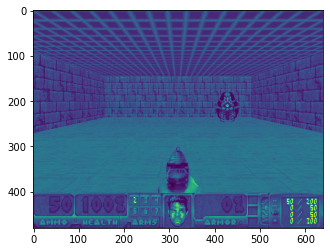

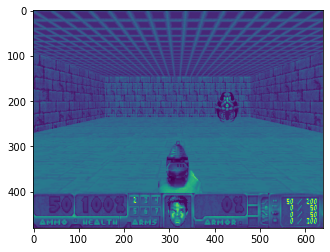

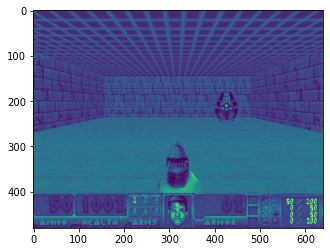

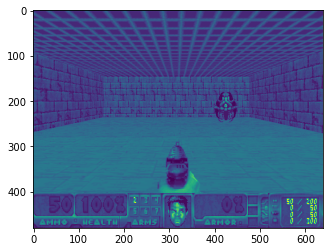

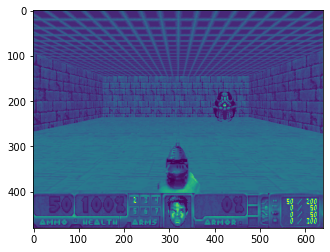

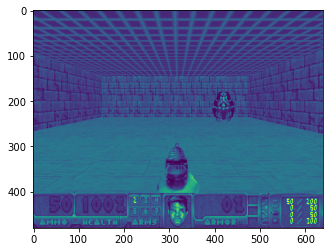

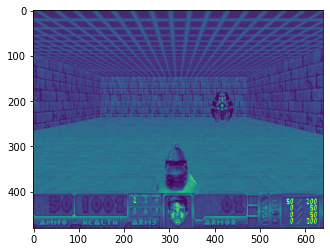

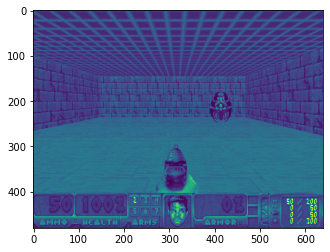

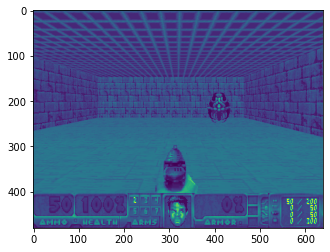

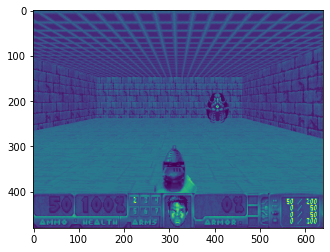

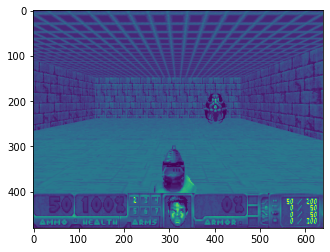

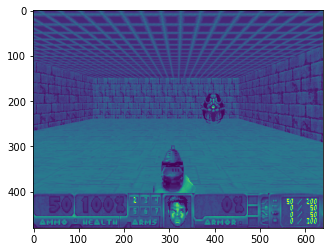

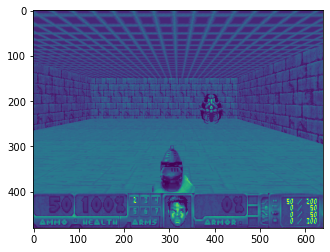

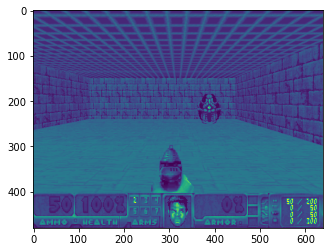

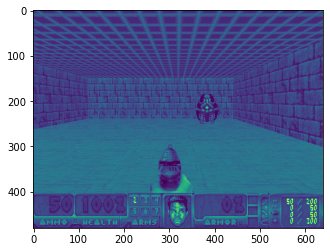

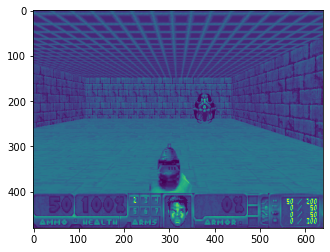

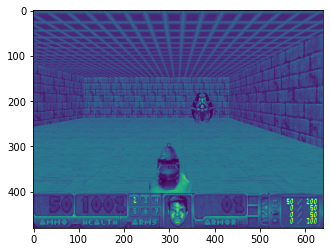

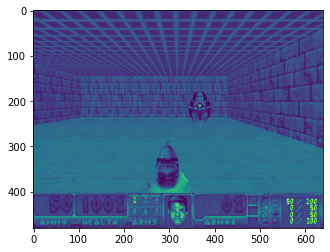

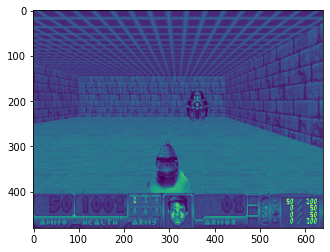

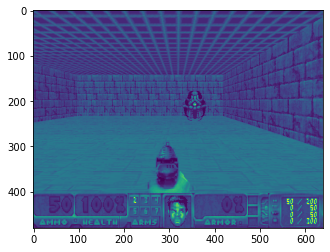

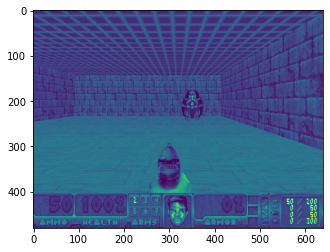

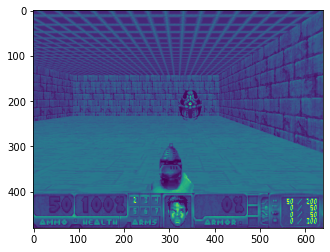

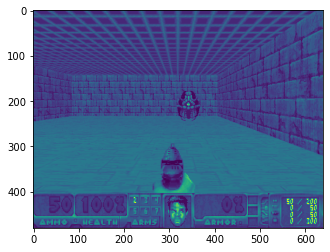

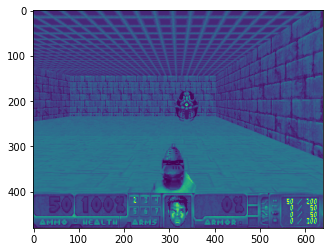

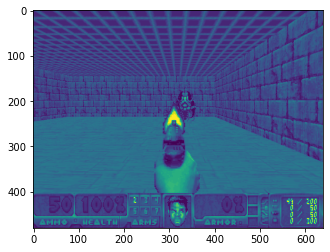

In [27]:
for image in img_frames:
    plt.imshow(image)
    plt.show()